<h1><center>SINr : manipuler et évaluer un modèle SINr</center></h1>
Page Github : https://github.com/SINr-Embeddings/sinr/tree/main
    
Documentation : https://sinr-embeddings.github.io/sinr/_build/html/modules.html

Publications :
-  (https://hal.science/hal-03197434). Thibault Prouteau, Victor Connes, Nicolas Dugué, Anthony Perez,
   Jean-Charles Lamirel, et al.. SINr: Fast Computing of Sparse
   Interpretable Node Representations is not a Sin!. Advances in
   Intelligent Data Analysis XIX, 19th International Symposium on
   Intelligent Data Analysis, IDA 2021, Apr 2021, Porto, Portugal.
   pp.325-337,
-  (https://hal.science/hal-03770444). Thibault Prouteau, Nicolas Dugué, Nathalie Camelin, Sylvain Meignier.
   Are Embedding Spaces Interpretable? Results of an Intrusion Detection
   Evaluation on a Large French Corpus. LREC 2022, Jun 2022, Marseille,
   France.
-  (https://hal.science/hal-04321407). Simon Guillot, Thibault Prouteau, Nicolas Dugué.
   Sparser is better: one step closer to word embedding interpretability.
   IWCS 2023, Nancy, France.
-  (https://hal.science/hal-04398742). Anna Béranger, Nicolas Dugué, Simon Guillot, Thibault Prouteau.
   Filtering communities in word co-occurrence networks to foster the
   emergence of meaning. Complex Networks 2023, Menton, France.

Dans ce notebook :
- À quoi ressemble le modèle ?
- Présentation des modèles, sparsification, méthode SINr-filtered
- Comment évaluer les performances d'un modèle avec la similarité
- Comment évaluer l'interprétabilité d'un modèle avec le DistRatio
- Comment utiliser un modèle SINr dans une tâche de classification
- Comment charger un modèle Word2vec avec la librairie SINr

Pour un exemple de pré-traitement, d'entraînement, de sparsification et de l'application de la méthode SINr-Filtered sur un modèle SINr, voir le notebook preprocess_train. 

In [3]:
import sinr.graph_embeddings as ge
import sinr.text.evaluate as ev
import sinr.viz as viz
import sinr.text.preprocess as ppcs
from sklearn.datasets import fetch_20newsgroups
import xgboost as xgb

## Présentation des modèles

Dans ce notebook, deux modèles sont utilisés, un entraîné sur FrWac, corpus en français, et un entraîné sur BNC (British National Corpus), corpus en anglais. Les deux corpus sont disponibles dans le répertoire notebooks du projet GitHub.

Les deux corpus sont pré-traités, de sorte à avoir :
- Des mots lemmatisés
- Uniquement des noms communs, des adjectifs et des verbes
- Des mots présents plus de 20 fois dans les corpus

Le corpus FrWac a été filtré avec le lefff (https://www.labri.fr/perso/clement/lefff/).

Les modèles sont entraînés avec un gamma de 50.

Le modèle FrWac a été sparsifié pour avoir maximum 100 valeurs non nulles par vecteur de mot. Le modèle BNC a été sparsifié pour avoir maximum 160 valeurs non nulles par vecteur de mot.

Les deux modèles ont été filtrés par la méthode SINr-Filtered.

SINr-Filtered s'appuyant sur la tâche de similarité et n'ayant pas de data set de similarité en français à disposition, les seuils de filtrage d'un modèle en anglais de même taille ont été calculés avec la méthode SINr-Filtered. Ces seuils ont été appliqués sur le modèle français :
- Les dimensions avec moins de 800 valeurs non nulles ont été supprimées
- Les dimensions avec plus de 3800 valeurs non nulles ont été supprimées

Pour le modèle BNC :
- Les dimensions avec moins de 600 valeurs non nulles ont été supprimées
- Les dimensions avec plus de 2900 valeurs non nulles ont été supprimées

In [5]:
# charge le fichier sinrvec_frwac.pk
model_fr = ge.SINrVectors('frwac_gamma50_spars20_filtered')
model_fr.load('./sinrvec_frwac.pk')

# charge le fichier sinrvec_bnc.pk
model_en = ge.SINrVectors('bnc_gamma50_spars20_filtered')
model_en.load('./sinrvec_bnc.pk')

## Représentations du modèle français

Dans la librairie SINr :
- les 'stereotypes' d'une dimension sont des mots ayant une valeur non nulle sur cette dimension
- les 'descriptors' d'une dimension sont les mots qui constituent la communauté qui est associée à la dimension

Quels sont les mots les plus proches de 'montagne'?

In [8]:
model_fr.most_similar('montagne')

{'object ': 'montagne',
 'neighbors ': [('colline', 0.79),
  ('plaine', 0.7),
  ('vallée', 0.7),
  ('surplomber', 0.65),
  ('contrebas', 0.64),
  ('boisé', 0.63),
  ('escarpé', 0.62),
  ('rocheux', 0.62),
  ('mont', 0.61),
  ('coteau', 0.61),
  ('lac', 0.61),
  ('falaise', 0.6),
  ('enneigé', 0.59),
  ('flanc', 0.58),
  ('percher', 0.58),
  ('ravin', 0.58),
  ('forêt', 0.57),
  ('promontoire', 0.57),
  ('dévaler', 0.57),
  ('border', 0.57),
  ('vallon', 0.57),
  ('rocher', 0.56),
  ('versant', 0.55),
  ('montagnard', 0.55),
  ('rivière', 0.55),
  ('pente', 0.54),
  ('abrupt', 0.52),
  ('bordure', 0.52),
  ('butte', 0.52),
  ('désert', 0.51)]}

De quelle communauté le mot 'montagne' est-il membre ?

In [9]:
model_fr.get_dimension_descriptors('montagne')

{'dimension': 61, 'descriptors': [(0.05, 'enneiger'), (0.05, 'treillage'), (0.01, 'accompagnateur'), (0.01, 'montagne'), (0.01, 'renoncer')]}

In [10]:
# La communauté d'une dimension peut être également obtenue en passant par l'index de la dimension
model_fr.get_dimension_descriptors_idx(61)

{'dimension': 61, 'descriptors': [(0.05, 'enneiger'), (0.05, 'treillage'), (0.01, 'accompagnateur'), (0.01, 'montagne'), (0.01, 'renoncer')]}

Quels mots ont les plus grandes valeurs sur cette dimension ?

In [12]:
model_fr.get_dimension_stereotypes('montagne')
# voir aussi model_fr.get_dimension_stereotypes_idx(61)

{'dimension': 61, 'stereotypes': [(0.11, 'verglacer'), (0.05, 'treillage'), (0.05, 'enneiger'), (0.04, 'enneigé'), (0.03, 'remontrer')]}

Par quelles dimensions 'montagne' est représenté ?

In [14]:
model_fr.get_obj_stereotypes_and_descriptors('montagne')
# voir aussi get_obj_stereotypes('montagne') et get_obj_descriptors('montagne')

[{'dimension': 28,
  'value': True,
  'stereotypes': [(0.15, 'crayeux'),
   (0.11, 'anfractuosité'),
   (0.08, 'abrupt')],
  'descriptors': [(0.15, 'crayeux'),
   (0.11, 'anfractuosité'),
   (0.08, 'abrupt')]},
 {'dimension': 61,
  'value': True,
  'stereotypes': [(0.11, 'verglacer'),
   (0.05, 'treillage'),
   (0.05, 'enneiger')],
  'descriptors': [(0.05, 'enneiger'),
   (0.05, 'treillage'),
   (0.01, 'accompagnateur')]},
 {'dimension': 166,
  'value': True,
  'stereotypes': [(0.11, 'oued'), (0.1, 'mugir'), (0.08, 'torrentiel')],
  'descriptors': [(0.11, 'oued'), (0.07, 'affluent'), (0.05, 'draine')]},
 {'dimension': 428,
  'value': True,
  'stereotypes': [(0.15, 'transitif'),
   (0.12, 'verglacer'),
   (0.12, 'automorphisme')],
  'descriptors': [(0.15, 'transitif'),
   (0.12, 'automorphisme'),
   (0.07, 'morphisme')]},
 {'dimension': 448,
  'value': True,
  'stereotypes': [(0.17, 'finage'), (0.12, 'comtal'), (0.11, 'inexpugnable')],
  'descriptors': [(0.17, 'finage'), (0.12, 'comtal'

Le module viz permet de comparer des mots par leur stéréotypes :

In [15]:
sinr_viz = viz.SINrViz(model_fr)

{705, 643, 932, 231, 136, 393, 616, 296, 140, 13, 685, 175, 780, 849, 178, 249}


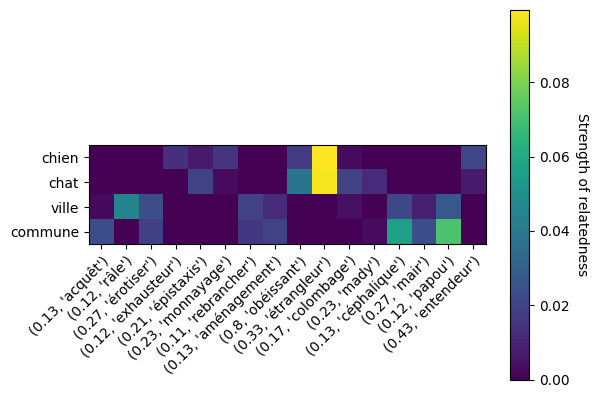

In [34]:
sinr_viz.compare_stereotypes(["chien", "chat", "ville", "commune"], topk_dim=5)

## Tâche de similarité : évaluer les performances du modèle

La librairie SINr permet de récupérer plusieurs data sets de similarité : MEN, WS353, SCWS et SimLex (665, 999, 222 et 111). Ce sont des data sets en anglais, on ne peut donc pas évaluer le modèle français.

Pour effectuer la tâche sur un modèle anglais, on peut, soit récupérer un data set en particulier et évaluer le modèle :

In [35]:
men = ev.fetch_data_MEN()
ev.eval_similarity(model_en, men)

eval similarity:   0%|          | 0/3000 [00:00<?, ?it/s]

1 missing words


0.7101779663902481

soit utiliser une méthode qui évalue le modèle sur MEN, WS353 et SCWS :

In [36]:
ev.similarity_MEN_WS353_SCWS(model_en)

eval similarity:   0%|          | 0/3000 [00:00<?, ?it/s]

1 missing words


eval similarity:   0%|          | 0/353 [00:00<?, ?it/s]

0 missing words


eval similarity:   0%|          | 0/1994 [00:00<?, ?it/s]

15 missing words


{'MEN': 0.7101779663902481,
 'WS353': 0.5719125743645842,
 'SCWS': 0.5707449776963844}

## DistRatio : évaluer l'interprétabilité d'un modèle
Cette évaluation ne nécessite pas de data set, il est donc possible de l'appliquer sur un modèle quelque soit la langue.

In [37]:
ev.dist_ratio(model_fr)

  0%|          | 0/944 [00:00<?, ?it/s]

  0%|          | 0/944 [00:00<?, ?it/s]

2.8858133390138496

In [38]:
ev.dist_ratio(model_en)

  0%|          | 0/1431 [00:00<?, ?it/s]

  0%|          | 0/1431 [00:00<?, ?it/s]

2.6505558240643543

## Classification de documents textuels

Pour cet exemple, on utilisera le data set de classification 20 Newsgroup, la tâche sera donc appliquée sur le modèle anglais.

Récupération du data set :

In [39]:
datas_test = fetch_20newsgroups(subset='test', remove=('headers', 'footers', 'quotes'), categories=['alt.atheism', 'soc.religion.christian'])
X_test = datas_test.data
y_test = datas_test.target

datas_train = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'), categories=['alt.atheism', 'soc.religion.christian'])
X_train = datas_train.data
y_train = datas_train.target

Pré-traitement des documents, similaire à celui appliqué sur le corpus BNC pour l'entraînement du modèle SINr:

In [40]:
# Tout d'abord, il faut mettre les documents dans un fichier .txt en séparant les documents par un séparateur
separator = '#DOC#'

with open('./train_#DOC#.txt', 'w+') as file:
    for x in X_train:
        file.write(separator)
        file.write(x)
file.close()

with open('./test_#DOC#.txt', 'w+') as file:
    for x in X_test:
        file.write(separator)
        file.write(x)
file.close()

In [41]:
# Ensuite, il faut créer un fichier .vrt, afin de pouvoir appliquer le pré-traitement de notre choix
vrt_maker = ppcs.VRTMaker(ppcs.Corpus(ppcs.Corpus.REGISTER_WEB,
                                  ppcs.Corpus.LANGUAGE_EN,
                                  './train_#DOC#.txt'),
                                  ".", n_jobs=8)
vrt_maker.do_txt_to_vrt(separator=separator)
docs_train = ppcs.extract_text('./train_#DOC#.vrt', min_length_doc=-1)

vrt_maker = ppcs.VRTMaker(ppcs.Corpus(ppcs.Corpus.REGISTER_WEB,
                                  ppcs.Corpus.LANGUAGE_EN,
                                  './test_#DOC#.txt'),
                                  ".", n_jobs=8)
vrt_maker.do_txt_to_vrt(separator=separator)
docs_test = ppcs.extract_text('./test_#DOC#.vrt', min_length_doc=-1)

2024-06-14 09:30:52,182 - do_txt_to_vrt - INFO - 1079lines to preprocess


  0%|          | 0/1079 [00:00<?, ?it/s]

2024-06-14 09:31:44,647 - do_txt_to_vrt - INFO - VRT-style file written in /export/home/lium/aberanger/sinr/notebooks/train_#DOC#.vrt


  0%|          | 0/392185 [00:00<?, ?it/s]

2024-06-14 09:31:52,890 - do_txt_to_vrt - INFO - 717lines to preprocess


  0%|          | 0/717 [00:00<?, ?it/s]

2024-06-14 09:32:30,610 - do_txt_to_vrt - INFO - VRT-style file written in /export/home/lium/aberanger/sinr/notebooks/test_#DOC#.vrt


  0%|          | 0/286318 [00:00<?, ?it/s]

Vectorisation des documents avec les embeddings SINr

In [43]:
X_train, y_train = ev.vectorizer(model_en, docs_train, y=y_train)
X_test, y_test = ev.vectorizer(model_en, docs_test, y=y_test)

Il faut maintenant choisir un modèle de classification (par défaut, XGBoost) et l'entraîner sur les données d'entraînement. On peut alors obtenir le score de la tâche sur les données de test.

In [44]:
clf = ev.clf_fit(X_train, y_train, clf=xgb.XGBClassifier())
ev.clf_score(clf, X_test, y_test)

0.7266081871345029

Avec XGBoost, il est possible de regarder quelles dimensions ont été le plus utilisées :

In [46]:
ev.clf_xgb_interpretability(model_en, clf, 'stereotypes', topk_dim=10, topk=5, importance_type='gain')

([{'dimension': 1133, 'stereotypes': [(0.14, 'mantis'), (0.09, 'supplication'), (0.07, 'thanksgiving'), (0.06, 'thankfulness'), (0.06, 'meditation')]},
  {'dimension': 257, 'stereotypes': [(0.26, 'fructose'), (0.23, 'beet'), (0.18, 'cornflour'), (0.16, 'granulated'), (0.16, 'caster')]},
  {'dimension': 619, 'stereotypes': [(0.19, 'bungee'), (0.13, 'bandwagon'), (0.09, 'ya'), (0.04, 'parachute'), (0.04, 'jumping')]},
  {'dimension': 31, 'stereotypes': [(0.07, 'genocidal'), (0.06, 'tsarist'), (0.06, 'authoritarian'), (0.06, 'totalitarian'), (0.05, 'repressive')]},
  {'dimension': 837, 'stereotypes': [(0.12, 'jerry'), (0.05, 'bodyshell'), (0.05, 'obsolescence'), (0.04, 'mw'), (0.04, 'basilican')]},
  {'dimension': 1264, 'stereotypes': [(0.08, 'fourpence'), (0.07, 'thruppence'), (0.06, 'threepence'), (0.06, 'sixpence'), (0.06, 'ninepence')]},
  {'dimension': 850, 'stereotypes': [(0.09, 'inhumation'), (0.07, 'cremate'), (0.07, 'hatchet'), (0.07, 'cemetery'), (0.06, 'churchyard')]},
  {'dime

## Charger un modèle Word2vec
Il est possible de charger un modèle Word2vec dans un objet SINrVectors afin de l'évaluer.

In [ ]:
w2v_model = ge.SINrVectors.w2v_model("word2vec_model")